In [1]:
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.9 MB/s eta 0:00:00


In [2]:
!pip install tensorflow

In [10]:
# Importing dependencies
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.utils import load_dataset
from tensorflow.keras.models import Sequential

# Disabling eager execution from TF 2
tf.compat.v1.disable_eager_execution()

In [4]:
# Load dataset
(train_images, train_labels), (test_images, test_labels), min_, max_ = load_dataset('mnist')

In [13]:
def create_model():
    model = Sequential([
        Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
        MaxPool2D(pool_size=2),
        Dropout(0.25),
        Conv2D(64, kernel_size=3, activation='relu'),
        MaxPool2D(pool_size=2),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create an instance of the model
model = create_model()

# Print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 5, 5, 64)         

In [14]:
# Instantiating the model
model = create_model()

# Training the model
model.fit(
    x=train_images,
    y=train_labels,
    epochs=5,
    batch_size=256)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 45s 750us/sample - loss: 0.4554 - accuracy: 0.8565
Epoch 2/5
60000/60000 [==============================] - 44s 730us/sample - loss: 0.1421 - accuracy: 0.9566
Epoch 3/5
60000/60000 [==============================] - 47s 776us/sample - loss: 0.1060 - accuracy: 0.9683
Epoch 4/5
60000/60000 [==============================] - 45s 755us/sample - loss: 0.0889 - accuracy: 0.9733
Epoch 5/5
60000/60000 [==============================] - 44s 732us/sample - loss: 0.0768 - accuracy: 0.9776


In [15]:
# Assuming min_val and max_val are the actual minimum and maximum values for clipping or normalization
min_val = 0.0
max_val = 1.0

# Creating a classifier by wrapping our TF model in ART's KerasClassifier class
classifier = KerasClassifier(
    model=model,
    clip_values=(min_val, max_val)
)

In [16]:
# Defining an attack using the fast gradient method
attack_fgsm = FastGradientMethod(
    estimator=classifier,
    eps=0.5
    )

In [17]:
test_images_adv = attack_fgsm.generate(x=test_images)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [18]:
# Evaluating the model on clean images
score_clean = model.evaluate(
    x=test_images,
    y=test_labels
    )

# Evaluating the model on adversarial images
score_adv = model.evaluate(
    x=test_images_adv,
    y=test_labels
    )

# Comparing test losses
print(f"Clean test set loss: {score_clean[0]:.2f} "
      f"vs adversarial set test loss: {score_adv[0]:.2f}")

# Comparing test accuracies
print(f"Clean test set accuracy: {score_clean[1]:.2f} "
      f"vs adversarial test set accuracy: {score_adv[1]:.2f}")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Clean test set loss: 0.03 vs adversarial set test loss: 3.92
Clean test set accuracy: 0.99 vs adversarial test set accuracy: 0.04


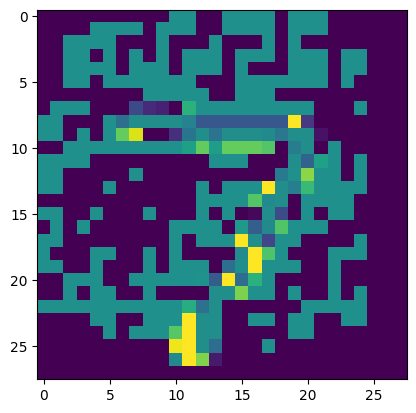

In [19]:
plt.imshow(X=test_images_adv[0])


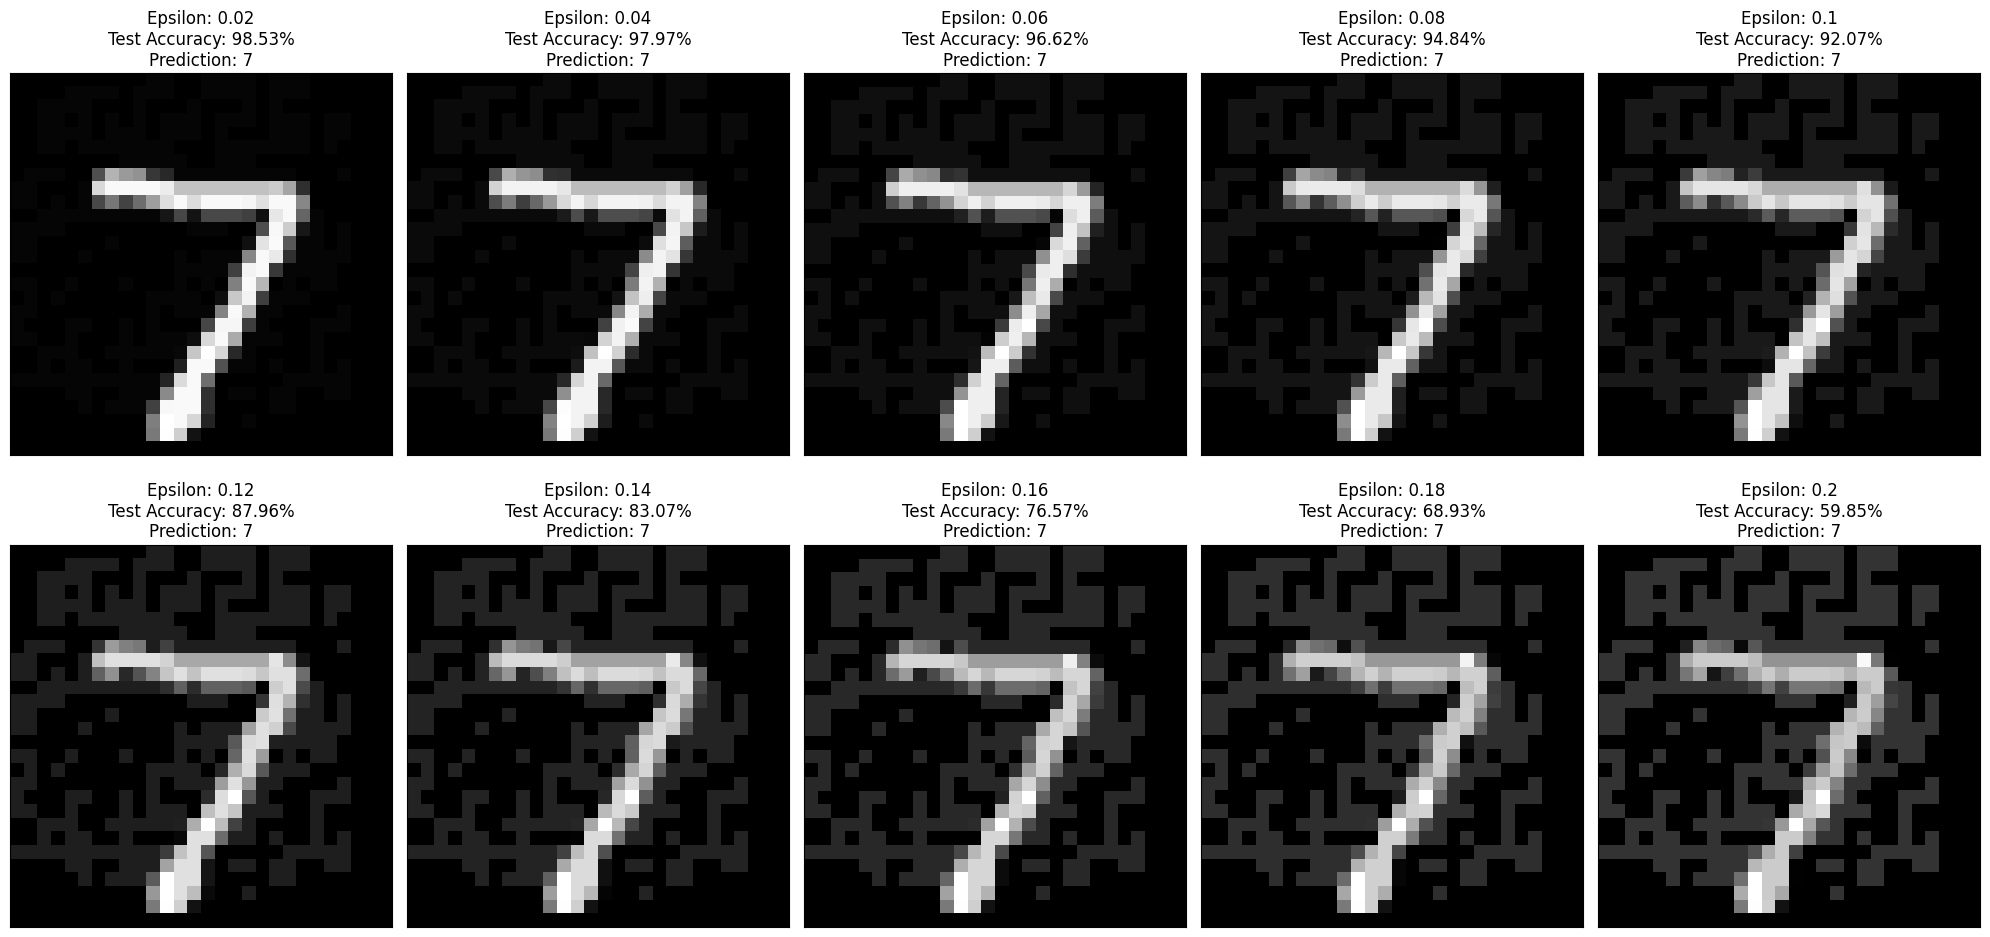

In [20]:
# Set the number of rows and columns for the figure
num_rows, num_cols = 2, 5

# Generate subplots
fig, axes = plt.subplots(
    nrows=num_rows,
    ncols=num_cols,
    figsize=(20, 10)
)

# Define epsilon values to try
eps_to_try = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]

# Counter to iterate through eps_to_try
counter = 0

# Iterate over rows and columns
for i in range(num_rows):
    for j in range(num_cols):
        # Create Fast Gradient Sign Method (FGSM) attack object with current epsilon
        attack_fgsm = FastGradientMethod(
            estimator=classifier,
            eps=eps_to_try[counter]
        )

        # Generate adversarial images
        adversarial_images = attack_fgsm.generate(x=test_images)

        # Display the first adversarial image in grayscale
        axes[i, j].imshow(adversarial_images[0].squeeze(), cmap='gray')

        # Disable x and y ticks
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

        # Evaluate model performance on adversarial samples and retrieve test accuracy
        test_accuracy = classifier._model.evaluate(
            x=adversarial_images,
            y=test_labels,
            verbose=0  # Set verbose to 0 to suppress output during evaluation
        )[1]

        # Get prediction for the displayed image
        prediction = np.argmax(classifier.predict(np.expand_dims(adversarial_images[0], axis=0)))

        # Set title with epsilon value, test accuracy, and prediction
        axes[i, j].set_title(
            f"Epsilon: {eps_to_try[counter]}\n"
            f"Test Accuracy: {test_accuracy * 100:.2f}%\n"
            f"Prediction: {prediction}"
        )

        # Increment counter for next epsilon value
        counter += 1

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()